In [ ]:
### Author: Claudio S. Quiroga-Lombard

In [ ]:
"""
Description:  There are two sides in a ride-hailing marketplace: riders (demand) and drivers (supply). 
One of the challenges that we aim to solve is efficient supply allocation, 
so riders can always get a ride and drivers have stable earnings. 
Knowledge about how demand changes over time and space is crucial to comprehend supply dynamics. 

Tasks: 

-Explore the data and suggest a solution to guide the drivers towards areas with higher expected demand at 
given time and location
-Build and document a baseline model for your solution
-Describe how you would design and deploy such a model
-Describe how to communicate model recommendations to drivers
-Think through and describe the design of the experiment  that would validate your solution for 
live operations taking into account marketplace specifics

Data Description:

The source data is approximately 630000 rows of synthetic ride demand data:

start_time - time when the order was made
start_lat - latitude of the order's pick-up point
start_lng - longitude of the order's pick-up point
end_lat - latitude of the order's destination point
end_lng - longitude of the order's destination point
ride_value - how much monetary value is in this particular ride
"""

### Get Data

In [1]:
import pandas as pd
import numpy as np

PATH = 'C:\\Users\\celes\\3D Objects\\Data\\Data_for_Tasks\\'

# chunksize= is a very useful argument because the output of read_csv after passing it is an iterator, 
# so you can call the next() function on it to get the specific chunk you want without straining your memory. 
# ref https://stackoverflow.com/questions/23853553/python-pandas-how-to-read-only-first-n-rows-of-csv-files-in

chunks = []
chunks = pd.read_csv(PATH + '\\robotex5.csv') #, chunksize = 100000) 

In [2]:
df = []
#df = next(chunks) ### if chunksize argument is used.
df = chunks.copy()

df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%d %H:%M:%S')

print("df dimensions:", df.shape)

df.head()

df dimensions: (627210, 6)


,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100


### Latitude & Longitude Bins


In [24]:

min_lat = df.start_lat.min()
max_lat = df.start_lat.max()

min_lng = df.start_lng.min()
max_lng = df.start_lng.max()

print(min_lat, max_lat, min_lng, max_lng)

int_lat = 0.08
int_lng = 0.15

bin_lat = np.arange(min_lat, max_lat, int_lat).tolist()
bin_lng = np.arange(min_lng, max_lng, int_lng).tolist()

bin_lat, bin_lng

59.32155738688771 59.56699804588873 24.505199098293403 24.973743413626107


([59.32155738688771, 59.40155738688771, 59.48155738688771, 59.561557386887706],
 [24.505199098293403, 24.6551990982934, 24.8051990982934, 24.9551990982934])

In [17]:
max_lat

59.56699804588873

### Time Bins

In [25]:
### Data sampled from 2020-03-1 to 2022-03-28
start_time = df.start_time.min() 
end_time = df.start_time.max()

print(start_time, end_time)

2022-03-01 00:00:07.936317 2022-03-28 23:59:53.175658


In [26]:
### Binn data in 30 minutes frames. 

time_bins = []
time_bins = pd.date_range(start_time,end_time,freq='30 min')
print(time_bins[0], time_bins[-1], len(time_bins))

2022-03-01 00:00:07.936317 2022-03-28 23:30:07.936317 1344


### Plot the whole data with the geo bins

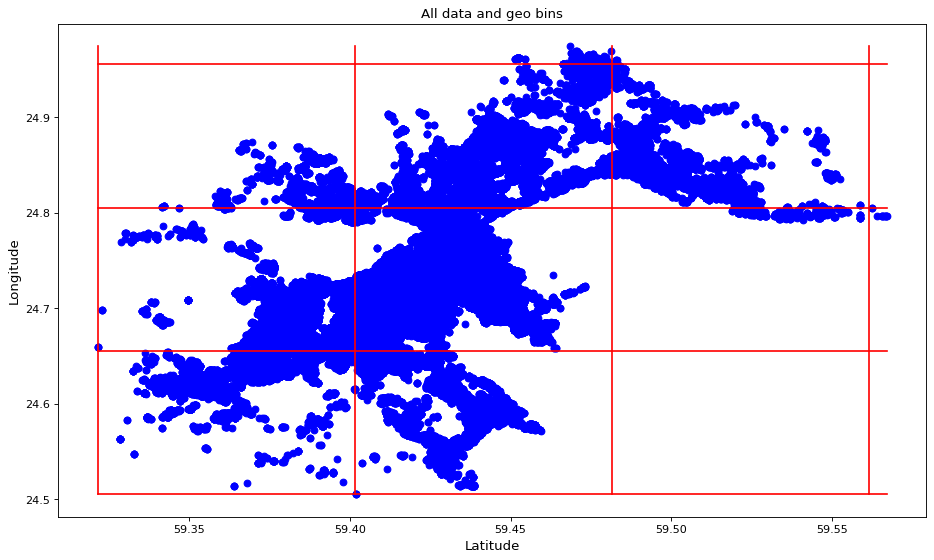

In [29]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(14, 8), dpi=80)

x = df.start_lat.values
y = df.start_lng.values

for BIN in bin_lat:
    plt.plot([BIN, BIN], [min(y), max(y)], c='r')
for BIN in bin_lng:
    plt.plot([min(x), max(x)], [BIN, BIN], c='r')
    
plt.scatter(x, y, c='b')

plt.title('All data and geo bins', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Longitude', fontsize=12)
plt.show()

In [36]:
z=0
time_bins[z+1] - time_bins[z]

Timedelta('0 days 00:30:00')

### Create Time Series

#### For each time bin, count the number of rides that fall into a geo-bin.

In [39]:

time_series = [] ### time_series to forecast.

for z in range(0, len(time_bins)-1):
        
    df_time_section = []
    df_time_section = df[(df.start_time >= time_bins[z]) & (df.start_time < time_bins[z+1])]
    
    #"""
    
    for i in range(0,len(bin_lat)-1):
        for j in range(0,len(bin_lng)-1):
        
            df_time_lat_long_section = []
            df_time_lat_long_section = df_time_section[(df_time_section.start_lat >= bin_lat[i]) &
                                                      (df_time_section.start_lat < bin_lat[i+1]) &
                                                      (df_time_section.start_lng >= bin_lng[j]) &
                                                      (df_time_section.start_lng < bin_lng[j+1])]
            
            
            ### Create time series

            time = []
            time = (time_bins[z+1] - time_bins[z])/2 + time_bins[z] 

            latitude = []
            latitude = int_lat/2 + bin_lat[i]

            longitude = []
            longitude = int_lng/2 + bin_lng[j]

            number_of_rides = []
            number_of_rides = len(df_time_lat_long_section)

            time_series.append([time, number_of_rides, latitude, longitude])
    
    
    
time_series = pd.DataFrame(time_series, columns=['time', 'number_of_rides', 'latitude', 'longitude'])

time_series.head()

,time,number_of_rides,latitude,longitude
0,2022-03-01 00:15:07.936317,7,59.361557,24.580199
1,2022-03-01 00:15:07.936317,19,59.361557,24.730199
2,2022-03-01 00:15:07.936317,0,59.361557,24.880199
3,2022-03-01 00:15:07.936317,12,59.441557,24.580199
4,2022-03-01 00:15:07.936317,263,59.441557,24.730199


In [40]:
latitude_list = time_series.latitude.unique()
longitude_list = time_series.longitude.unique()

latitude_list, longitude_list

(array([59.36155739, 59.44155739, 59.52155739]),
 array([24.5801991, 24.7301991, 24.8801991]))

In [78]:
 selected_time_series.number_of_rides.std()

5.1703883302021545

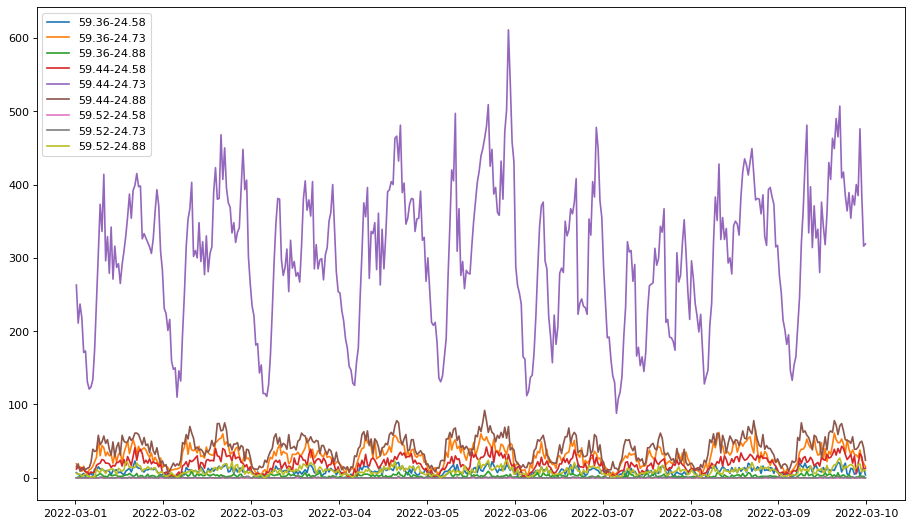

In [80]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(14, 8), dpi=80)

for lat in latitude_list:
    for lng in longitude_list:

        Name = str(round(lat,2)) + '-' + str(round(lng,2))
        
        selected_time_series = []
        selected_time_series = time_series[(time_series.latitude == lat) & (time_series.longitude == lng)].copy()
        selected_time_series = selected_time_series[selected_time_series.time < '2022-03-10'].copy()
        
        mean_rides = selected_time_series.number_of_rides.mean()
        std_rides =  selected_time_series.number_of_rides.std()
        
        #plt.plot(selected_time_series.time, (selected_time_series.number_of_rides - mean_rides)/std_rides, label = Name)
        plt.plot(selected_time_series.time, selected_time_series.number_of_rides, label = Name)
        plt.legend()

In [ ]:
### The center Bin is clearly the most populated one (more rides). Moreover the bins look highly correlated.
### Look at the same plot but with standardize variables.
### This means that we could focuss or forcast on the centered bin.
### This can also be seen in this simple animation. Where the majority of rides are located in the centered bin.

### My Animation

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np

for z in range(0, 100): #len(time_bins)-1):
        
    clear_output(wait=True)
    
    figure(figsize=(14, 8), dpi=80)

    df_time_section = []
    df_time_section = df[(df.start_time >= time_bins[z]) & (df.start_time < time_bins[z+1])]
   
    x = df_time_section.start_lat.values
    y = df_time_section.start_lng.values
    
    time = []
    time = (time_bins[z+1] - time_bins[z])/2 + time_bins[z] 
    
    plt.plot(x, y, 'o', label = time)

    for BIN in bin_lat:
        plt.plot([BIN, BIN], [min(df.start_lng.values), max(df.start_lng.values)], c='r')
    for BIN in bin_lng:
        plt.plot([min(df.start_lat.values), max(df.start_lat.values)], [BIN, BIN], c='r')
    
    plt.title('All data and geo bins', fontsize=12)
    plt.xlabel('Latitude', fontsize=12)
    plt.ylabel('Longitude', fontsize=12)
    plt.legend()
    
    plt.show()

### Make Forecast only for the centered bin / time series

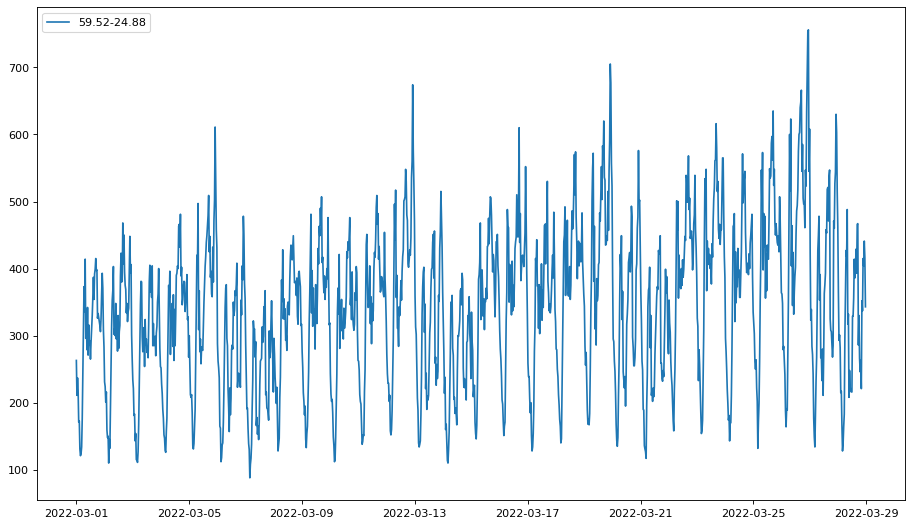

In [73]:
lat = latitude_list[1]
lng = longitude_list[1]

selected_time_series = []
selected_time_series = time_series[(time_series.latitude == lat) & (time_series.longitude == lng)].copy()
  
figure(figsize=(14, 8), dpi=80)
plt.plot(selected_time_series.time, selected_time_series.number_of_rides, label = Name)
plt.legend()

In [ ]:
### To Do Liste

### Make Forecast for the centered bin. Try a simple Sarimax model. 